<a href="https://colab.research.google.com/github/sidvin101/explainable-nn/blob/main/explainable_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #07
### This assigment is for my Explainable AI course in Duke University.
### Siddarth


## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "explainable-nn" # Change to your repo name
git_path = 'https://github.com/sidvin101/explainable-nn.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'explainable-nn' already exists and is not an empty directory.


# Hypothesis

## H0
When analyzing a bird, the model uses the beak as the most important feature to classify it.

## H1
When analyzing a bird, the model uses another part og the bird as the most important feature.

For testing this hypothesis, we will be using a saliency map. The process is as follows.


1.   With the image, perform a forward pass of the neural neteotk
2.   With respect to the pixel inputs (and making sure to set the other classes to zero), compute the gradient of the class score
3.   Portray the gradients through a visual.



Calculate the gradient of the loss function for the class of interest with respect to the input pixels

Process:

Perform a forward pass of image of interest
Compute the gradient of the class score of interest with respect to the input pixels (set all other classes to zero)
Visualize the gradients (show absolute values or highlight negative and positive contributions)

In [2]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
 

In [2]:
# Basic
import numpy as np
import matplotlib.pyplot as plt
import glob

# Model Utils
import tensorflow as tf
from PIL import Image

# Data Utils
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

In [3]:
# Function to generate a saliency map for an input image based on a given model

def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable
    x = tf.Variable(img)

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0])

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency, top_pred_index.numpy()


In [4]:
# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Download the ImageNet class index file
class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')

# Load ImageNet class labels
with open(class_index_path) as f:
    class_idx = json.load(f)

35363/35363 [==============================] - 0s 0us/step


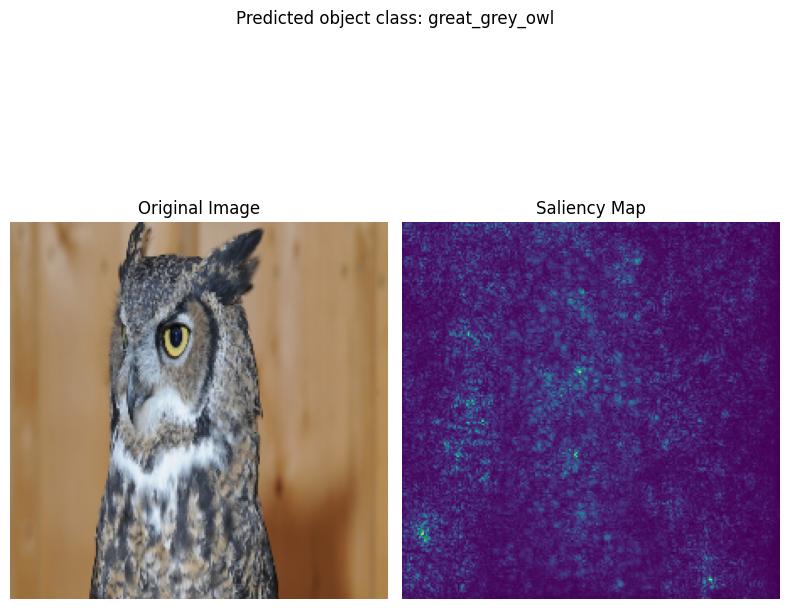

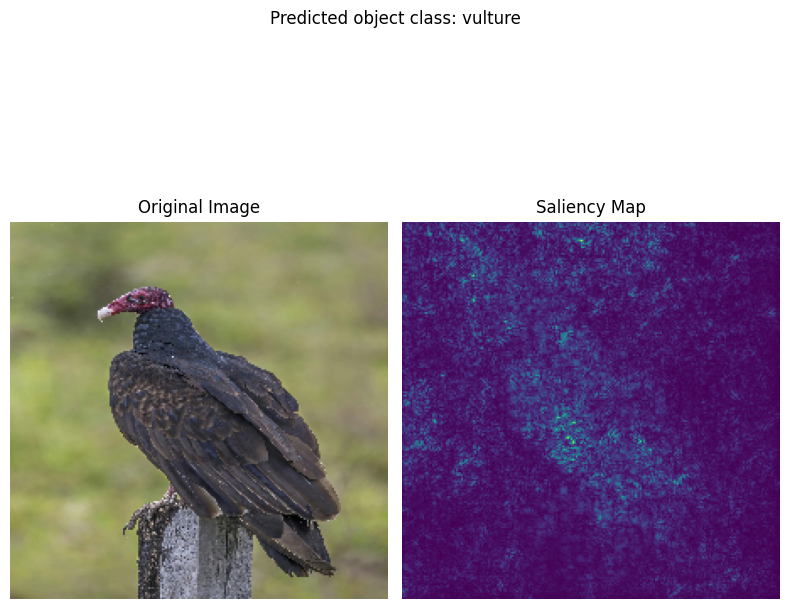

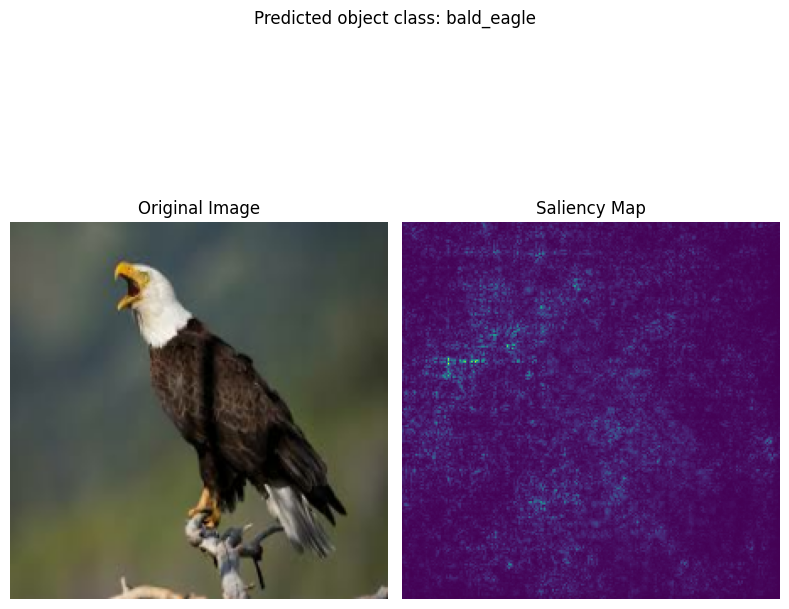

In [5]:
folder_path = '/content/explainable-nn/images'

# Get a list of all image files in the folder (supports multiple formats)
image_files = glob.glob(os.path.join(folder_path, '*'))

# Iterate through each image file
for img_path in image_files:
    # Load the image from file path
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img.numpy().astype(np.float32)

    # Generate saliency map
    saliency_map, top_pred_index = generate_saliency_map(model, img)

    # Map the index to class label
    predicted_class = class_idx[str(top_pred_index)][1]

    # Display the original image
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    plt.tight_layout()

    # Display the saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='viridis')
    plt.title("Saliency Map")
    plt.suptitle(f"Predicted object class: {predicted_class}")
    plt.axis('off')
    plt.tight_layout()

    plt.show()

#Analysis

I chose these three birds because each one has very distinct beak shapes, and I wanted to know whether or not they would be the primary indicator for their class. For the eagle and owl, this hypothesis seems to be correct, as the most highlighted regions on the saliency map correspond to the head region. However, when looking at a bird like the vulture, a lot of the highlighted pixels are around the wing area. Thus, this rejects the null hypothesis, concluding that there are multiple features such as bird wings that can have a primary classification effect over other features, such as the aforementioned beak.